In [8]:
#Setting up Gerrychain to import the graph.
from gerrychain import Graph

In [10]:
#Setting up the file path to read 'ID_county.json' from the folder 'districting-data'.
filepath = 'districting-data/'
filename = 'ID_county.json'

#Gerrychains code for creating a graph from the file.
G = Graph.from_json( filepath + filename )

In [11]:
for node in G.nodes:
     #The population of each county.
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [12]:
#Imposing a 1.0% population deviation (+/-0.5%)
deviation = 0.01

import math
#k is the number of districts j, selected for the model.
k = 2
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 914956 and U = 924150 and k = 2


In [13]:
#Importing Gurobipy and importing GRB from Gurobipy.
import gurobipy as gp
from gurobipy import GRB

#Creating the model.  
m = gp.Model()

#Creating the variables x[i,j] equals one when county i is assigned to district j,
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)
#and y[u,v] equals one when edge {u,v} is cut.
y = m.addVars(G.edges, vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-12


In [14]:
#The objective is to minimize cut edges.
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [15]:
#Adding constraints saying that each county i is assigned to one district.
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

#Adding constraints saying that each district has population at least L and at most U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

#Adding constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

#Updating the model.
m.update()

In [16]:
#Adding root variables: r[i,j] equals 1 if node i is the "root" of district j.
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

#Adding contiguity constraints.
import networkx as nx
DG = nx.DiGraph(G)

f = m.addVars( DG.edges )

In [17]:
#The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

#Each district j should have one root.
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

#If node i is not assigned to district j, then it cannot be its root.
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 
#If not a root, consume some flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             #If a root, only send out (so much) flow.
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

#Do not send flow across cut edges.
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

#Updating the model.
m.update()

In [18]:
#Optimizing the model.
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 488 rows, 482 columns and 1942 nonzeros
Model fingerprint: 0x7b03cf5a
Variable types: 204 continuous, 278 integer (278 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+05]
Presolve removed 46 rows and 44 columns
Presolve time: 0.01s
Presolved: 442 rows, 438 columns, 1766 nonzeros
Variable types: 204 continuous, 234 integer (234 binary)

Root relaxation: objective 0.000000e+00, 113 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   48          -    0.00000      -     -    0s
     0     0    0

In [19]:
print("The number of cut edges is",m.objval)

#Retrieve the districts and their populations.
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

#Printing district info.
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 11.0
District 0 has population 921109 and contains counties ['Lemhi', 'Cassia', 'Oneida', 'Boise', 'Fremont', 'Bannock', 'Twin Falls', 'Owyhee', 'Gooding', 'Caribou', 'Bear Lake', 'Lincoln', 'Camas', 'Canyon', 'Jefferson', 'Franklin', 'Madison', 'Clark', 'Jerome', 'Custer', 'Bonneville', 'Teton', 'Power', 'Blaine', 'Elmore', 'Butte', 'Valley', 'Minidoka', 'Bingham']

District 1 has population 917997 and contains counties ['Ada', 'Clearwater', 'Payette', 'Shoshone', 'Lewis', 'Washington', 'Latah', 'Boundary', 'Kootenai', 'Gem', 'Idaho', 'Benewah', 'Nez Perce', 'Adams', 'Bonner']



In [20]:
#Drawing the model as a map using Gurobi.
import geopandas as gpd

In [25]:
#Read the Idaho county shapefile from "ID_county.shp".
filepath = 'districting-data/'
filename = 'ID_county.shp'

#Read geopandas dataframe from file.
df = gpd.read_file( filepath + filename )

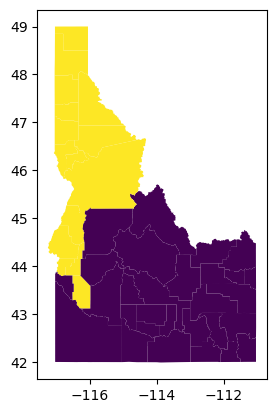

In [26]:
#Assigning each county i to district j.
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

#Adding the assignments to a column of the dataframe and mapping it.
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

#Pick a position u in the dataframe.
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    #Determining what node in the geoid.
    i = node_with_this_geoid[geoid]
    
    #The position u in the dataframe should be given the same district # that county i has in 'labeling'.
    assignment[u] = labeling[i]
    
#Adding the assignments to a column of our dataframe and then mapping it.
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()